## Project 

### Import Lib

In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
#permet d'afficher toutes les lignes
#suppress -> chiffres en notation normal et pas en format scientifique
import pandas as pd
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

### Import data 

In [3]:
na_values = ['na']

In [4]:
data = pd.read_csv('./fbref/fbref_team_player_stats_for_combined_latest.csv', sep=',',na_values=na_values)

In [5]:
# Filtrage en gardant seulement championnat
data = data.loc[data["League Name"]!='Champions-League']
data = data.loc[data["League Name"]!='Europa-League']
data

Squad  # Pl  Age  Poss  MP  Starts   Min   90s  Gls  Ast  ...  PKwon  \
0       Alavés    26   26  42.7  38     418  3420  38.0   39   27  ...      2   
1       Alavés    30   28  42.7  38     418  3420  38.0   35   21  ...      5   
2       Alavés    30   28  41.8  24     264  2160  24.0   18    9  ...      5   
3       Alavés    30   25  39.8  38     418  3420  38.0   40   31  ...      3   
4       Alavés    32   27  41.1  38     418  3420  38.0   34   20  ...      5   
..         ...   ...  ...   ...  ..     ...   ...   ...  ...  ...  ...    ...   
485  Wolfsburg    29   25  49.2  34     374  3060  34.0   36   26  ...      6   
486     Wolves    21   26  46.9  38     418  3420  38.0   46   35  ...      3   
487     Wolves    21   26  48.3  38     418  3420  38.0   49   34  ...      4   
488     Wolves    21   27  48.1  23     253  2070  23.0   20   11  ...      1   
489     Wolves    27   26  49.3  38     418  3420  38.0   34   21  ...      3   

     PKcon  OG   Recov    Won   Lost  Won%     League Name  League ID  \
0        6   2  3512.0  702.0  721.0  49.3         La-Liga         12   
1        2   0  3047.0  920.0  690.0  57.1         La-Liga         12   
2        5   0  2050.0  655.0  476.0  57.9         La-Liga         12   
3       10   2  3509.0  376.0  381.0  49.7         La-Liga         12   
4       14   0  3348.0  823.0  617.0  57.2         La-Liga         12   
..     ...  ..     ...    ...    ...   ...             ...        ...   
485      9   2  3206.0  486.0  543.0  47.2      Bundesliga         20   
486      4   4  3536.0  717.0  645.0  52.6  Premier-League          9   
487      3   1  3569.0  719.0  701.0  50.6  Premier-League          9   
488      4   0  1871.0  345.0  373.0  48.1  Premier-League          9   
489      8   3  3005.0  620.0  595.0  51.0  Premier-League          9   

        Season  
0    2018-2019  
1    2020-2021  
2    2021-2022  
3    2017-2018  
4    2019-2020  
..         ...  
485  2017-2018  
486  2018-2019  
487  2019-2020  
488  2021-2022  
489  2020-2021  

[490 rows x 159 columns]

### Data preprocessing 

In [6]:
# Colonnes utiles
mycolumns = ['Squad_id','90s','CrdY','CrdR','Gls/90','Ast/90','xG/90','xA/90','Sh/90','SoT/90','Dist','FK','Cmp','Att',\
             'TotDist','PrgDist','Cmp_short','Att_short','Cmp_medium','Att_medium','Cmp_long','Att_long','KP','1/3','PPA',\
             'CrsPA','Prog','SCA90','PassLive','PassDead','Drib','Fld','Def','GCA90','PassLive_AMB','PassDead_AMB','Drib_AMB',\
            'Fld_AMB','Def_AMB','Tkl','TklW','Def 3rd','Mid 3rd','Att 3rd','Tkl_dribble','Past','Succ','Def 3rd_pression', \
             'Mid 3rd_pression','Att 3rd_pression','Touches','Def Pen','Att Pen','Carries','CPA','Fls']

In [7]:
len(mycolumns)

56

In [8]:
# recodage des modalités
data['Season'] = data['Season'].str.split('-')

In [9]:
data['Season'] = [elem[1] for elem in data['Season']]

In [10]:
display(data['Season'])

0      2019
1      2021
2      2022
3      2018
4      2020
       ... 
485    2018
486    2019
487    2020
488    2022
489    2021
Name: Season, Length: 490, dtype: object

In [11]:
data['Squad_id']=data['Squad']+data['Season']

In [12]:
data['Squad_id']

0         Alavés2019
1         Alavés2021
2         Alavés2022
3         Alavés2018
4         Alavés2020
           ...      
485    Wolfsburg2018
486       Wolves2019
487       Wolves2020
488       Wolves2022
489       Wolves2021
Name: Squad_id, Length: 490, dtype: object

In [13]:
data_ok=data[mycolumns]
data_ok

Squad_id   90s   CrdY  CrdR  Gls/90  Ast/90  xG/90  xA/90  Sh/90  \
0       Alavés2019  38.0  101.0   1.0    1.03    0.71   0.98   0.63  11.03   
1       Alavés2021  38.0   96.0   8.0    0.92    0.55   1.12   0.67   8.87   
2       Alavés2022  24.0   53.0   2.0    0.75    0.37   0.97   0.51   9.67   
3       Alavés2018  38.0  105.0   4.0    1.05    0.82   1.02   0.68  10.34   
4       Alavés2020  38.0  111.0   7.0    0.89    0.53   0.97   0.62   7.87   
..             ...   ...    ...   ...     ...     ...    ...    ...    ...   
485  Wolfsburg2018  34.0    NaN   NaN    1.06    0.76   1.15   0.74  10.26   
486     Wolves2019  38.0   73.0   1.0    1.21    0.92   1.29   0.89  12.29   
487     Wolves2020  38.0   61.0   2.0    1.29    0.89   1.24   0.85  11.92   
488     Wolves2022  23.0   40.0   1.0    0.87    0.48   1.01   0.67  10.39   
489     Wolves2021  38.0   55.0   1.0    0.89    0.55   1.05   0.70  12.16   

     SoT/90  ...    Succ  Def 3rd_pression  Mid 3rd_pression  \
0      3.11  ...  1386.0            1963.0            2755.0   
1      2.61  ...  1510.0            1750.0            2544.0   
2      2.67  ...   903.0            1196.0            1606.0   
3      3.61  ...  1521.0            2161.0            3024.0   
4      2.61  ...  1464.0            1757.0            2820.0   
..      ...  ...     ...               ...               ...   
485    3.35  ...  1431.0            1843.0            2320.0   
486    3.71  ...  1661.0            2306.0            2842.0   
487    3.74  ...  1710.0            2387.0            2810.0   
488    3.48  ...  1013.0            1371.0            1423.0   
489    3.92  ...  1558.0            2105.0            2187.0   

     Att 3rd_pression  Touches  Def Pen  Att Pen  Carries    CPA    Fls  
0              1149.0  18585.0   2331.0    672.0  10284.0   67.0  551.0  
1              1157.0  18391.0   2289.0    640.0   9826.0  105.0  521.0  
2               758.0  11723.0   1540.0    415.0   6039.0   63.0  419.0  
3              1170.0  17627.0   2150.0    639.0  10639.0  110.0  614.0  
4              1032.0  17992.0   2141.0    563.0   9417.0   84.0  621.0  
..                ...      ...      ...      ...      ...    ...    ...  
485            1010.0  20226.0   2290.0    547.0  12990.0   94.0  447.0  
486             951.0  22796.0   2214.0    825.0  14501.0  177.0  412.0  
487            1054.0  22382.0   2106.0    840.0  14114.0  212.0  406.0  
488             567.0  13678.0   1656.0    453.0   8748.0  112.0  287.0  
489             903.0  22963.0   2287.0    759.0  14457.0  183.0  427.0  

[490 rows x 56 columns]

In [14]:
#Données non normalisées
liste_90 = ['CrdY','CrdR','Dist','FK','Cmp','Att',\
             'TotDist','PrgDist','Cmp_short','Att_short','Cmp_medium','Att_medium','Cmp_long','Att_long','KP','1/3','PPA',\
             'CrsPA','Prog','PassLive','PassDead','Drib','Fld','Def','PassLive_AMB','PassDead_AMB','Drib_AMB',\
            'Fld_AMB','Def_AMB','Tkl','TklW','Def 3rd','Mid 3rd','Att 3rd','Tkl_dribble','Past','Succ','Def 3rd_pression', \
             'Mid 3rd_pression','Att 3rd_pression','Touches','Def Pen','Att Pen','Carries','CPA','Fls']

In [15]:
data_ok_flt=data_ok.copy()

In [16]:
# Boucle pour normaliser les données (qui ne l'étaient pas)
for i in liste_90:
    data_ok_flt[str(i)]=data_ok[str(i)]/data_ok['90s']
del data_ok['90s']
data_ok_flt

Squad_id   90s      CrdY      CrdR  Gls/90  Ast/90  xG/90  xA/90  \
0       Alavés2019  38.0  2.657895  0.026316    1.03    0.71   0.98   0.63   
1       Alavés2021  38.0  2.526316  0.210526    0.92    0.55   1.12   0.67   
2       Alavés2022  24.0  2.208333  0.083333    0.75    0.37   0.97   0.51   
3       Alavés2018  38.0  2.763158  0.105263    1.05    0.82   1.02   0.68   
4       Alavés2020  38.0  2.921053  0.184211    0.89    0.53   0.97   0.62   
..             ...   ...       ...       ...     ...     ...    ...    ...   
485  Wolfsburg2018  34.0       NaN       NaN    1.06    0.76   1.15   0.74   
486     Wolves2019  38.0  1.921053  0.026316    1.21    0.92   1.29   0.89   
487     Wolves2020  38.0  1.605263  0.052632    1.29    0.89   1.24   0.85   
488     Wolves2022  23.0  1.739130  0.043478    0.87    0.48   1.01   0.67   
489     Wolves2021  38.0  1.447368  0.026316    0.89    0.55   1.05   0.70   

     Sh/90  SoT/90  ...       Succ  Def 3rd_pression  Mid 3rd_pression  \
0    11.03    3.11  ...  36.473684         51.657895         72.500000   
1     8.87    2.61  ...  39.736842         46.052632         66.947368   
2     9.67    2.67  ...  37.625000         49.833333         66.916667   
3    10.34    3.61  ...  40.026316         56.868421         79.578947   
4     7.87    2.61  ...  38.526316         46.236842         74.210526   
..     ...     ...  ...        ...               ...               ...   
485  10.26    3.35  ...  42.088235         54.205882         68.235294   
486  12.29    3.71  ...  43.710526         60.684211         74.789474   
487  11.92    3.74  ...  45.000000         62.815789         73.947368   
488  10.39    3.48  ...  44.043478         59.608696         61.869565   
489  12.16    3.92  ...  41.000000         55.394737         57.552632   

     Att 3rd_pression     Touches    Def Pen    Att Pen     Carries       CPA  \
0           30.236842  489.078947  61.342105  17.684211  270.631579  1.763158   
1           30.447368  483.973684  60.236842  16.842105  258.578947  2.763158   
2           31.583333  488.458333  64.166667  17.291667  251.625000  2.625000   
3           30.789474  463.868421  56.578947  16.815789  279.973684  2.894737   
4           27.157895  473.473684  56.342105  14.815789  247.815789  2.210526   
..                ...         ...        ...        ...         ...       ...   
485         29.705882  594.882353  67.352941  16.088235  382.058824  2.764706   
486         25.026316  599.894737  58.263158  21.710526  381.605263  4.657895   
487         27.736842  589.000000  55.421053  22.105263  371.421053  5.578947   
488         24.652174  594.695652  72.000000  19.695652  380.347826  4.869565   
489         23.763158  604.289474  60.184211  19.973684  380.447368  4.815789   

           Fls  
0    14.500000  
1    13.710526  
2    17.458333  
3    16.157895  
4    16.342105  
..         ...  
485  13.147059  
486  10.842105  
487  10.684211  
488  12.478261  
489  11.236842  

[490 rows x 56 columns]

### Traitement des NaN

In [17]:
data_ok_flt.isna().sum(axis = 0)

Squad_id             0
90s                  0
CrdY                78
CrdR                78
Gls/90               0
Ast/90               0
xG/90                0
xA/90                0
Sh/90                0
SoT/90               0
Dist                 0
FK                   0
Cmp                  0
Att                  0
TotDist              0
PrgDist              0
Cmp_short            0
Att_short            0
Cmp_medium           0
Att_medium           0
Cmp_long             0
Att_long             0
KP                   0
1/3                  0
PPA                  0
CrsPA                0
Prog                 0
SCA90                0
PassLive             0
PassDead             0
Drib                 0
Fld                  0
Def                  0
GCA90                0
PassLive_AMB         0
PassDead_AMB         0
Drib_AMB             0
Fld_AMB              0
Def_AMB              0
Tkl                  0
TklW                 0
Def 3rd              0
Mid 3rd              0
Att 3rd    

In [18]:
#supprimer car NaN pour la saison 2017-2018
#a voir si données intéressantes pour les autres saisons

data_ok_flt=data_ok_flt.drop(columns=['CrdY'])
data_ok_flt=data_ok_flt.drop(columns=['CrdR'])

In [19]:
data_ok_flt.to_csv('data_ok_flt')

In [20]:
data_ok_flt

Squad_id   90s  Gls/90  Ast/90  xG/90  xA/90  Sh/90  SoT/90  \
0       Alavés2019  38.0    1.03    0.71   0.98   0.63  11.03    3.11   
1       Alavés2021  38.0    0.92    0.55   1.12   0.67   8.87    2.61   
2       Alavés2022  24.0    0.75    0.37   0.97   0.51   9.67    2.67   
3       Alavés2018  38.0    1.05    0.82   1.02   0.68  10.34    3.61   
4       Alavés2020  38.0    0.89    0.53   0.97   0.62   7.87    2.61   
..             ...   ...     ...     ...    ...    ...    ...     ...   
485  Wolfsburg2018  34.0    1.06    0.76   1.15   0.74  10.26    3.35   
486     Wolves2019  38.0    1.21    0.92   1.29   0.89  12.29    3.71   
487     Wolves2020  38.0    1.29    0.89   1.24   0.85  11.92    3.74   
488     Wolves2022  23.0    0.87    0.48   1.01   0.67  10.39    3.48   
489     Wolves2021  38.0    0.89    0.55   1.05   0.70  12.16    3.92   

         Dist        FK  ...       Succ  Def 3rd_pression  Mid 3rd_pression  \
0    0.465789  0.394737  ...  36.473684         51.657895         72.500000   
1    0.444737  0.289474  ...  39.736842         46.052632         66.947368   
2    0.716667  0.333333  ...  37.625000         49.833333         66.916667   
3    0.481579  0.578947  ...  40.026316         56.868421         79.578947   
4    0.434211  0.263158  ...  38.526316         46.236842         74.210526   
..        ...       ...  ...        ...               ...               ...   
485  0.538235  0.676471  ...  42.088235         54.205882         68.235294   
486  0.455263  0.315789  ...  43.710526         60.684211         74.789474   
487  0.444737  0.315789  ...  45.000000         62.815789         73.947368   
488  0.773913  0.434783  ...  44.043478         59.608696         61.869565   
489  0.465789  0.368421  ...  41.000000         55.394737         57.552632   

     Att 3rd_pression     Touches    Def Pen    Att Pen     Carries       CPA  \
0           30.236842  489.078947  61.342105  17.684211  270.631579  1.763158   
1           30.447368  483.973684  60.236842  16.842105  258.578947  2.763158   
2           31.583333  488.458333  64.166667  17.291667  251.625000  2.625000   
3           30.789474  463.868421  56.578947  16.815789  279.973684  2.894737   
4           27.157895  473.473684  56.342105  14.815789  247.815789  2.210526   
..                ...         ...        ...        ...         ...       ...   
485         29.705882  594.882353  67.352941  16.088235  382.058824  2.764706   
486         25.026316  599.894737  58.263158  21.710526  381.605263  4.657895   
487         27.736842  589.000000  55.421053  22.105263  371.421053  5.578947   
488         24.652174  594.695652  72.000000  19.695652  380.347826  4.869565   
489         23.763158  604.289474  60.184211  19.973684  380.447368  4.815789   

           Fls  
0    14.500000  
1    13.710526  
2    17.458333  
3    16.157895  
4    16.342105  
..         ...  
485  13.147059  
486  10.842105  
487  10.684211  
488  12.478261  
489  11.236842  

[490 rows x 54 columns]

In [21]:
#Séparation des variables 
X = data_ok_flt.drop(['Squad_id'], axis=1)

In [22]:
# Categorical variable
X_cat = data_ok_flt[['Squad_id']]

In [23]:
X_cat

Squad_id
0       Alavés2019
1       Alavés2021
2       Alavés2022
3       Alavés2018
4       Alavés2020
..             ...
485  Wolfsburg2018
486     Wolves2019
487     Wolves2020
488     Wolves2022
489     Wolves2021

[490 rows x 1 columns]

In [24]:
X.columns

Index(['90s', 'Gls/90', 'Ast/90', 'xG/90', 'xA/90', 'Sh/90', 'SoT/90', 'Dist',
       'FK', 'Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp_short', 'Att_short',
       'Cmp_medium', 'Att_medium', 'Cmp_long', 'Att_long', 'KP', '1/3', 'PPA',
       'CrsPA', 'Prog', 'SCA90', 'PassLive', 'PassDead', 'Drib', 'Fld', 'Def',
       'GCA90', 'PassLive_AMB', 'PassDead_AMB', 'Drib_AMB', 'Fld_AMB',
       'Def_AMB', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd',
       'Tkl_dribble', 'Past', 'Succ', 'Def 3rd_pression', 'Mid 3rd_pression',
       'Att 3rd_pression', 'Touches', 'Def Pen', 'Att Pen', 'Carries', 'CPA',
       'Fls'],
      dtype='object')

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer,KNNImputer

In [26]:
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_new = imp_num.fit_transform(X)
X_new = StandardScaler().fit_transform(X_new)

In [27]:
X_new.shape

(490, 53)

### Choix du nombre de clusters avec WCSS

In [28]:
wcss = []
K = range(1, 12)
for k in K:
  km = KMeans(n_clusters = k)
  km = km.fit(X_new)
  wcss.append(km.inertia_)

In [29]:
wcss

[25969.999999999996,
 17433.9486893612,
 15617.939954282101,
 14444.938496500617,
 13657.15203468968,
 13199.770444013111,
 12833.81788210736,
 12381.366662546603,
 12120.889427474296,
 11931.953389951874,
 11698.140314040513]

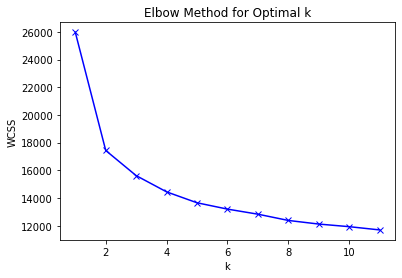

In [30]:
plt.plot(K, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k');

### PCA (Principal Component Analisys)

In [31]:
pca = PCA(n_components=0.8)
df_pca = pca.fit_transform(X_new)

In [32]:
df_pca

array([[-5.82144439, -1.39940303,  2.04024911,  1.08222314, -0.03470013,
         0.37690044, -0.02659724, -0.26084795],
       [-6.13258591, -2.89296343,  0.86344816,  1.3631808 ,  0.03998569,
         0.58379772,  0.71502608,  1.58480265],
       [-6.76384128, -1.57959809, -0.43551212,  3.20655125,  1.6276064 ,
        -0.58155515, -0.73676249,  1.49640612],
       [-6.23444759, -1.96250552,  2.4352203 , -0.73112894,  1.87807407,
        -0.80527979,  0.80611781,  0.30029757],
       [-7.66185121, -2.29809106,  0.89618367,  0.36296118, -0.06327452,
        -0.16836788,  0.36387113,  2.05750382],
       [-4.79929521,  0.14828598,  0.50030561, -1.5362299 , -0.33708582,
        -1.77678646,  0.06181367,  0.49835745],
       [-4.30479863,  1.70070618, -1.31395815, -1.93687283,  1.21502024,
        -2.22930444,  1.31681134,  3.19882043],
       [-5.85988729, -3.72728499, -0.72994208, -0.87041074,  0.84604901,
         0.36736826,  0.81047276,  0.10361064],
       [-2.99939222,  2.01565198

In [33]:
X_new.shape

(490, 53)

In [34]:
df_pca.shape

(490, 8)

In [35]:
pca.explained_variance_ratio_

array([0.47112695, 0.10142659, 0.05624099, 0.05222492, 0.04688286,
       0.02868776, 0.02665733, 0.02457058])

In [36]:
exp_var = [round(i, 1) for i in pca.explained_variance_ratio_ * 100]

In [37]:
exp_var

[47.1, 10.1, 5.6, 5.2, 4.7, 2.9, 2.7, 2.5]

In [38]:
summ=0
for i in exp_var:
    summ=summ+i

In [39]:
summ

80.80000000000001

### Choix du nombre de clusters avec la méthode de la silhouette

 https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters =  2  Average score:  0.3068441965366873
For n_clusters =  3  Average score:  0.17598818441505337
For n_clusters =  4  Average score:  0.12525734502951227
For n_clusters =  5  Average score:  0.11152405703263259
For n_clusters =  6  Average score:  0.10055190593836745
For n_clusters =  7  Average score:  0.09731338563772834
For n_clusters =  8  Average score:  0.09211703873157993
For n_clusters =  9  Average score:  0.08163296923234932
For n_clusters =  10  Average score:  0.08082417020052486
For n_clusters =  11  Average score:  0.0812577794050447


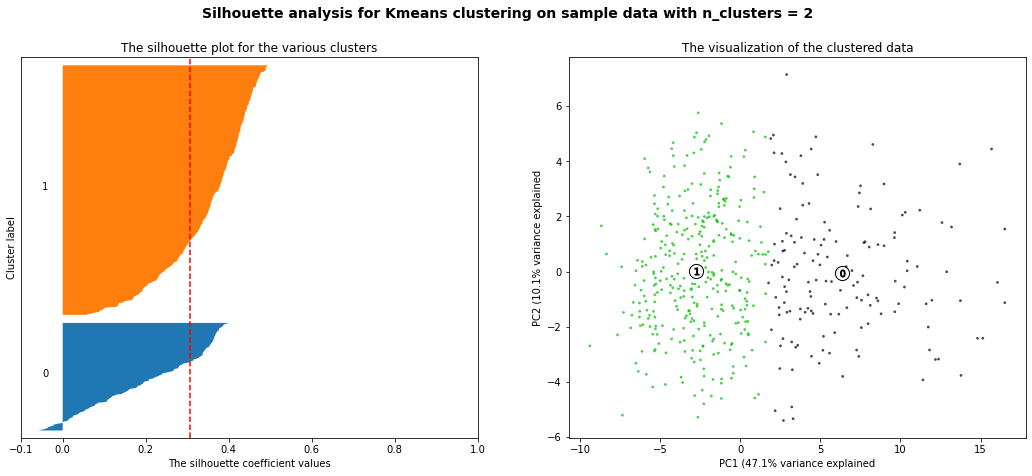

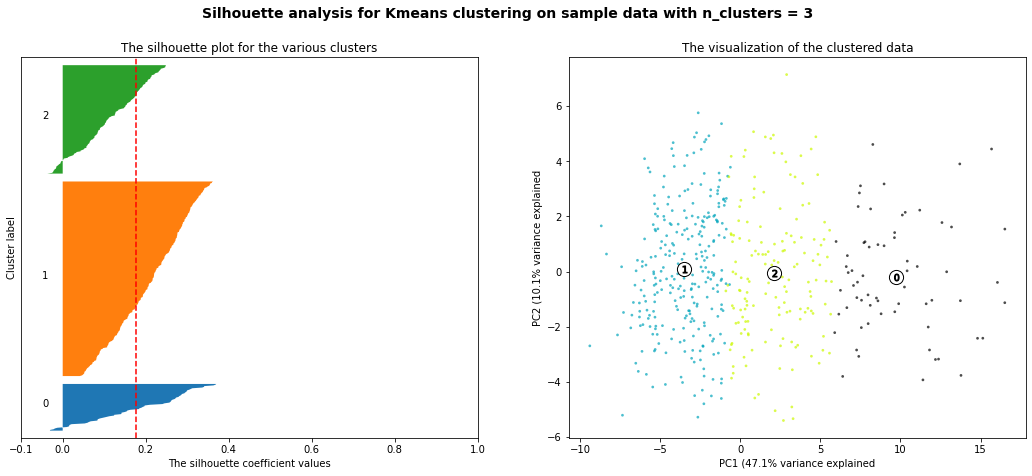

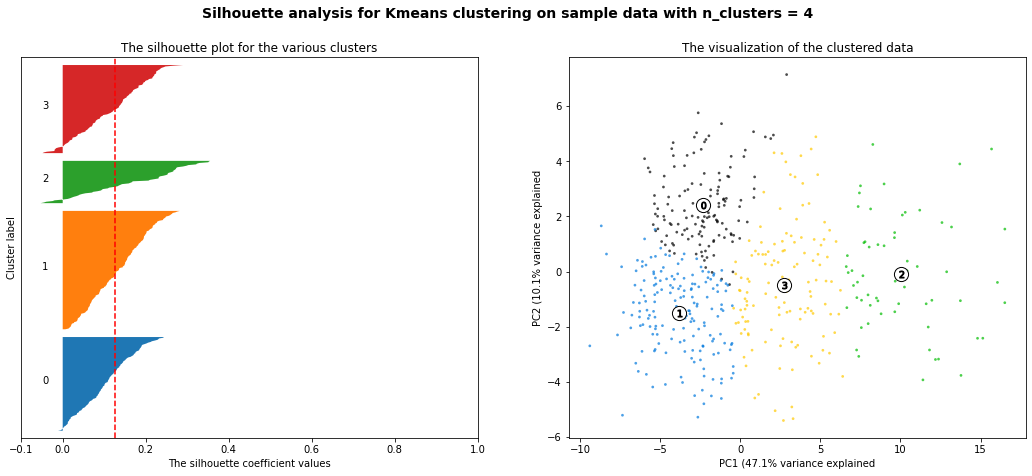

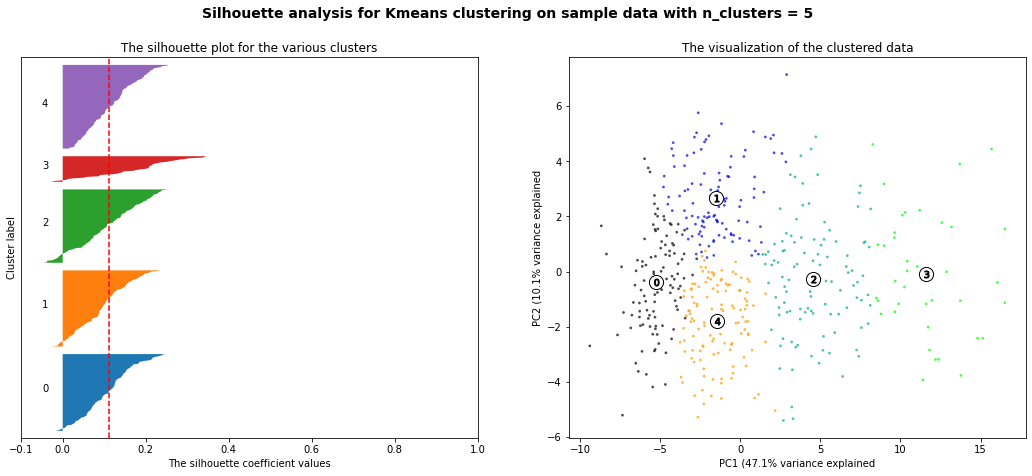

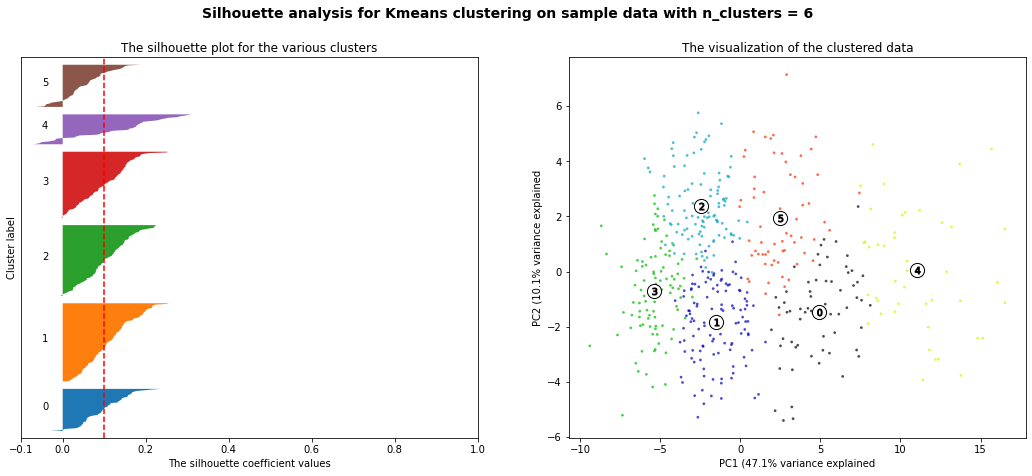

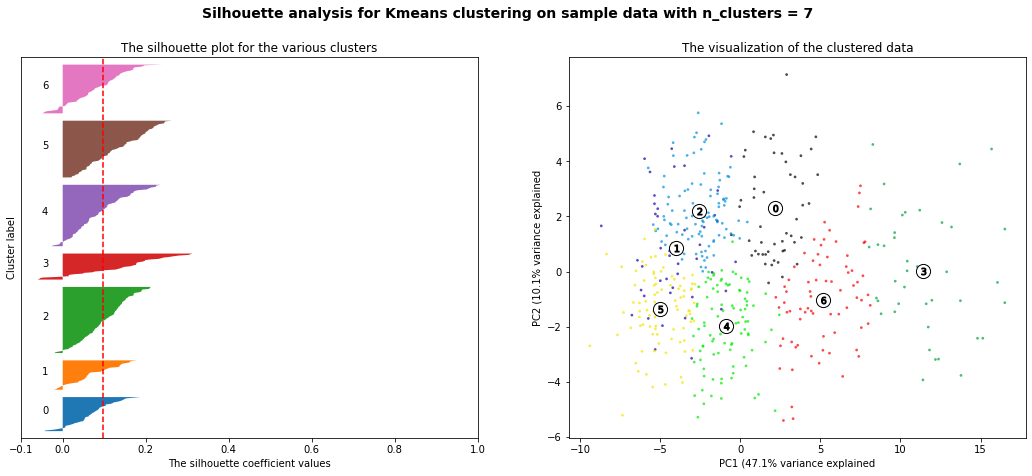

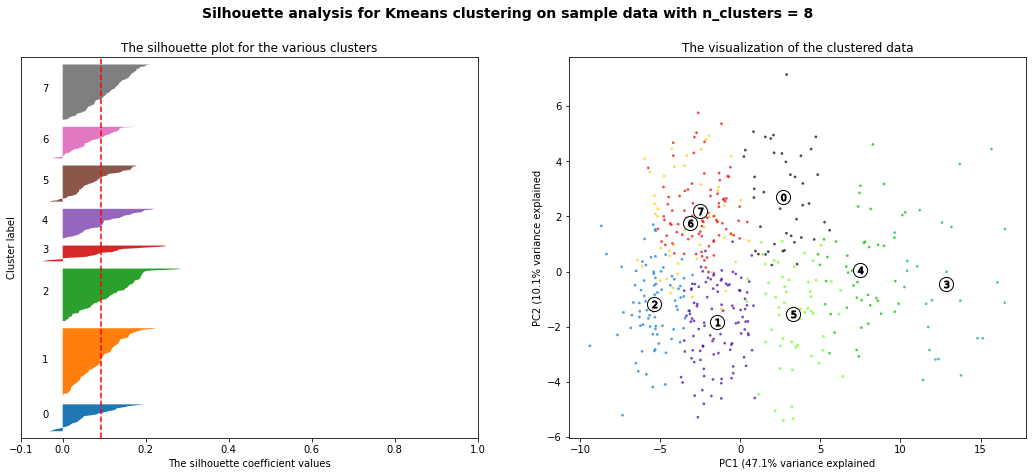

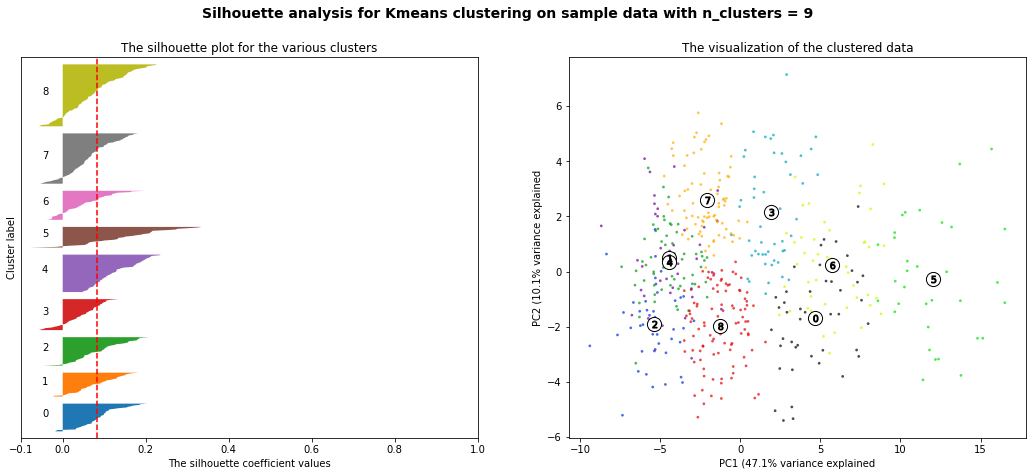

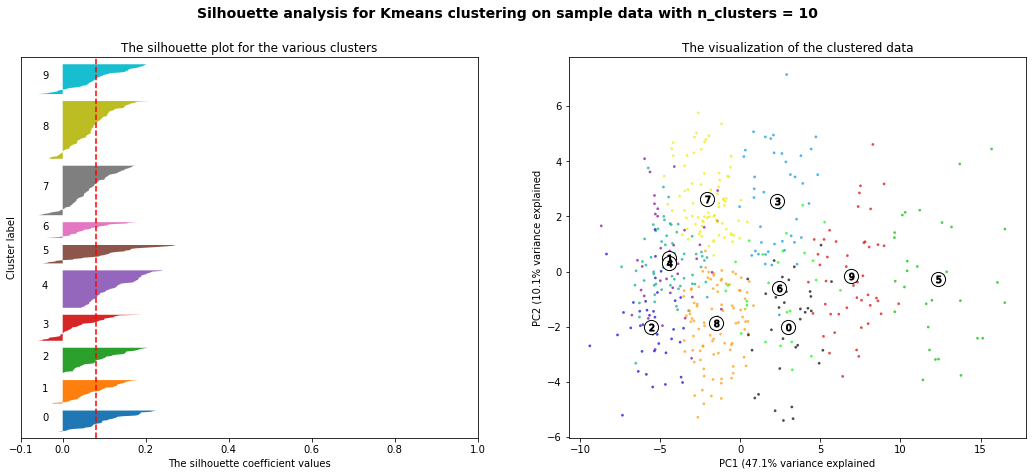

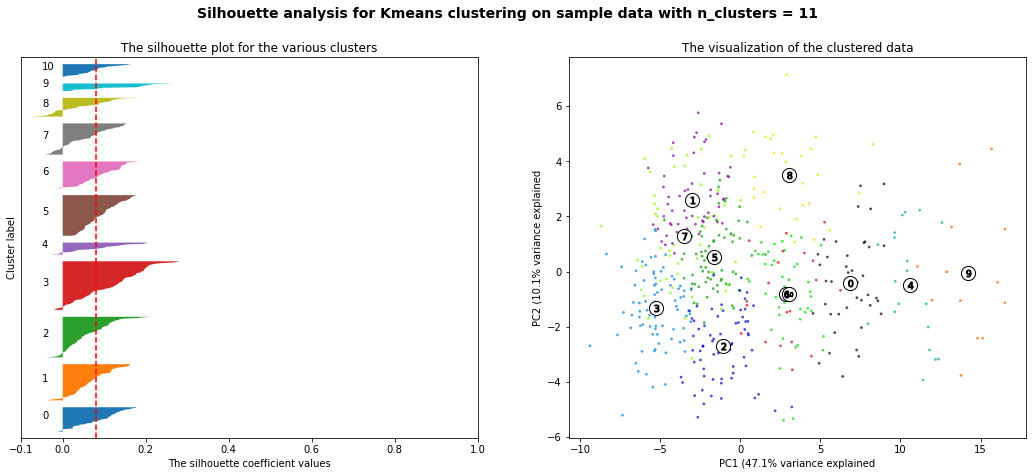

In [40]:
range_n_clusters = range(2, 12)
for n_clusters in range_n_clusters:
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(X_new) + (n_clusters + 1) * 10])

  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(X_new)
  #print(cluster_labels)
  #print(np.unique(cluster_labels))

  silhouette_avg = silhouette_score(X_new, cluster_labels)
  print("For n_clusters = ", n_clusters, " Average score: ", silhouette_avg)

  sample_silhouette_values = silhouette_samples(X_new, cluster_labels)
  #print(sample_silhouette_values)
  #print(len(sample_silhouette_values))

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    #print(ith_cluster_silhouette_values.shape)

    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i
    #print(y_upper)

    ax1.fill_betweenx(np.arange(y_lower, y_upper), ith_cluster_silhouette_values)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

  ax1.set_title("The silhouette plot for the various clusters")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")   

  ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

  ax1.set_yticks([])
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(df_pca[:, 0], df_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

  centers = clusterer.cluster_centers_
  centers = pca.transform(centers)
  ax2.scatter(centers[:, 0], centers[:,1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, s=50, edgecolor='k')

  ax2.set_title("The visualization of the clustered data")
  ax2.set_xlabel('PC1 (' + str(exp_var[0]) + '% variance explained')
  ax2.set_ylabel('PC2 (' + str(exp_var[1]) + '% variance explained')

  plt.suptitle(("Silhouette analysis for Kmeans clustering on sample data with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

### Application k-means

In [41]:
km = KMeans(n_clusters=2, n_init=100, random_state=0)
km.fit(X_new)

KMeans(n_clusters=2, n_init=100, random_state=0)

In [42]:
print(km.cluster_centers_)

[[ 0.00198419 -0.50326402 -0.47629708 -0.50596915 -0.51105298 -0.47436062
  -0.50200705  0.06921672 -0.15501759 -0.51434686 -0.5166651  -0.50799687
  -0.49584117 -0.48967183 -0.49265485 -0.50323695 -0.50517348 -0.38887127
  -0.13143895 -0.49565742 -0.51018501 -0.49674787 -0.1301345  -0.50872586
  -0.50337002 -0.51529378 -0.0427516  -0.32630491 -0.10321371 -0.11200511
  -0.50969439 -0.50659708 -0.10113359 -0.35865894 -0.23685582 -0.09997119
   0.11163792  0.03771544  0.30277653 -0.0619059  -0.26038306  0.06635212
   0.14478118 -0.03070443  0.36046725  0.14817148 -0.22688389 -0.51282051
   0.06648604 -0.49859064 -0.50550995 -0.47224055  0.19751823]
 [-0.00458508  1.16294794  1.10063245  1.16919899  1.18094676  1.09615765
   1.16004331 -0.15994675  0.35821631  1.18855829  1.19391531  1.17388465
   1.14579514  1.13153895  1.13843214  1.16288539  1.16736035  0.89860793
   0.30373055  1.14537053  1.17894105  1.14789035  0.30071621  1.17556922
   1.16319289  1.19074643  0.09879086  0.75402891

In [43]:
print(km.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1
 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0]


In [44]:
len(km.labels_)

490

In [45]:
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [49]:
name=['90s', 'Gls/90', 'Ast/90', 'xG/90', 'xA/90',
       'Sh/90', 'SoT/90', 'Dist', 'FK', 'Cmp', 'Att', 'TotDist', 'PrgDist',
       'Cmp_short', 'Att_short', 'Cmp_medium', 'Att_medium', 'Cmp_long',
       'Att_long', 'KP', '1/3', 'PPA', 'CrsPA', 'Prog', 'SCA90', 'PassLive',
       'PassDead', 'Drib', 'Fld', 'Def', 'GCA90', 'PassLive_AMB',
       'PassDead_AMB', 'Drib_AMB', 'Fld_AMB', 'Def_AMB', 'Tkl', 'TklW',
       'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl_dribble', 'Past', 'Succ',
       'Def 3rd_pression', 'Mid 3rd_pression', 'Att 3rd_pression', 'Touches',
       'Def Pen', 'Att Pen', 'Carries', 'CPA', 'Fls','Group']

In [50]:
len(name)

54

In [51]:
data_final = pd.DataFrame(np.concatenate((X_new,km.labels_.reshape((-1,1))),axis=1),columns=name)

In [52]:
data_final

90s    Gls/90    Ast/90     xG/90     xA/90     Sh/90    SoT/90  \
0    0.673639 -0.696957 -0.600081 -1.010795 -1.013215 -0.605257 -1.040560   
1    0.673639 -0.938399 -1.048654 -0.606123 -0.862368 -1.585943 -1.558284   
2   -1.753442 -1.311537 -1.553299 -1.039700 -1.465756 -1.222726 -1.496157   
3    0.673639 -0.653058 -0.291687 -0.895174 -0.824656 -0.918532 -0.522837   
4    0.673639 -1.004247 -1.104726 -1.039700 -1.050926 -2.039964 -1.558284   
..        ...       ...       ...       ...       ...       ...       ...   
485 -0.019813 -0.631109 -0.459902 -0.519408 -0.598385 -0.954853 -0.792053   
486  0.673639 -0.301870 -0.011329 -0.114736 -0.032709 -0.033190 -0.419292   
487  0.673639 -0.126276 -0.095436 -0.259261 -0.183556 -0.201178 -0.388229   
488 -1.926805 -1.048145 -1.244905 -0.924079 -0.862368 -0.895831 -0.657445   
489  0.673639 -1.004247 -1.048654 -0.808459 -0.749232 -0.092213 -0.201849   

         Dist        FK       Cmp  ...  Def 3rd_pression  Mid 3rd_pression  \
0   -0.559483 -0.516668 -1.429800  ...          0.138580          0.445717   
1   -0.745382 -1.039829 -1.292960  ...         -0.532066         -0.202449   
2    1.655818 -0.821845 -1.392145  ...         -0.079721         -0.206033   
3   -0.420059  0.398864 -1.566058  ...          0.761997          1.272051   
4   -0.838332 -1.170619 -1.456004  ...         -0.510026          0.645388   
..        ...       ...       ...  ...               ...               ...   
485  0.080229  0.883557 -0.135986  ...          0.443435         -0.052108   
486 -0.652433 -0.909039 -0.195038  ...          1.218539          0.712970   
487 -0.745382 -0.909039 -0.190089  ...          1.473573          0.614670   
488  2.161316 -0.317639 -0.122390  ...          1.089858         -0.795187   
489 -0.559483 -0.647458  0.148226  ...          0.585677         -1.299108   

     Att 3rd_pression   Touches   Def Pen   Att Pen   Carries       CPA  \
0           -0.642956 -1.397919 -0.333914 -0.878238 -1.409689 -1.535820   
1           -0.601535 -1.459023 -0.471311 -1.032472 -1.554856 -0.781718   
2           -0.378034 -1.405347  0.017209 -0.950134 -1.638613 -0.885903   
3           -0.534226 -1.699656 -0.926027 -1.037292 -1.297169 -0.682494   
4           -1.248737 -1.584694 -0.955469 -1.403599 -1.684492 -1.198459   
..                ...       ...       ...       ...       ...       ...   
485         -0.747422 -0.131591  0.413298 -1.170546 -0.067611 -0.780550   
486         -1.668125 -0.071600 -0.716661 -0.140805 -0.073074  0.647108   
487         -1.134830 -0.201995 -1.069966 -0.068508 -0.195737  1.341676   
488         -1.741737 -0.133826  0.990978 -0.509836 -0.088219  0.806729   
489         -1.916650 -0.019001 -0.477853 -0.458913 -0.087020  0.766177   

          Fls  Group  
0    0.893705    0.0  
1    0.465629    0.0  
2    2.497801    0.0  
3    1.792664    0.0  
4    1.892549    0.0  
..        ...    ...  
485  0.160101    0.0  
486 -1.089713    0.0  
487 -1.175328    0.0  
488 -0.202541    0.0  
489 -0.875675    0.0  

[490 rows x 54 columns]

In [54]:
X_cat=X_cat.reset_index(drop=True)
data_final['Squad']=X_cat
data_final

90s    Gls/90    Ast/90     xG/90     xA/90     Sh/90    SoT/90  \
0    0.673639 -0.696957 -0.600081 -1.010795 -1.013215 -0.605257 -1.040560   
1    0.673639 -0.938399 -1.048654 -0.606123 -0.862368 -1.585943 -1.558284   
2   -1.753442 -1.311537 -1.553299 -1.039700 -1.465756 -1.222726 -1.496157   
3    0.673639 -0.653058 -0.291687 -0.895174 -0.824656 -0.918532 -0.522837   
4    0.673639 -1.004247 -1.104726 -1.039700 -1.050926 -2.039964 -1.558284   
..        ...       ...       ...       ...       ...       ...       ...   
485 -0.019813 -0.631109 -0.459902 -0.519408 -0.598385 -0.954853 -0.792053   
486  0.673639 -0.301870 -0.011329 -0.114736 -0.032709 -0.033190 -0.419292   
487  0.673639 -0.126276 -0.095436 -0.259261 -0.183556 -0.201178 -0.388229   
488 -1.926805 -1.048145 -1.244905 -0.924079 -0.862368 -0.895831 -0.657445   
489  0.673639 -1.004247 -1.048654 -0.808459 -0.749232 -0.092213 -0.201849   

         Dist        FK       Cmp  ...  Mid 3rd_pression  Att 3rd_pression  \
0   -0.559483 -0.516668 -1.429800  ...          0.445717         -0.642956   
1   -0.745382 -1.039829 -1.292960  ...         -0.202449         -0.601535   
2    1.655818 -0.821845 -1.392145  ...         -0.206033         -0.378034   
3   -0.420059  0.398864 -1.566058  ...          1.272051         -0.534226   
4   -0.838332 -1.170619 -1.456004  ...          0.645388         -1.248737   
..        ...       ...       ...  ...               ...               ...   
485  0.080229  0.883557 -0.135986  ...         -0.052108         -0.747422   
486 -0.652433 -0.909039 -0.195038  ...          0.712970         -1.668125   
487 -0.745382 -0.909039 -0.190089  ...          0.614670         -1.134830   
488  2.161316 -0.317639 -0.122390  ...         -0.795187         -1.741737   
489 -0.559483 -0.647458  0.148226  ...         -1.299108         -1.916650   

      Touches   Def Pen   Att Pen   Carries       CPA       Fls  Group  \
0   -1.397919 -0.333914 -0.878238 -1.409689 -1.535820  0.893705    0.0   
1   -1.459023 -0.471311 -1.032472 -1.554856 -0.781718  0.465629    0.0   
2   -1.405347  0.017209 -0.950134 -1.638613 -0.885903  2.497801    0.0   
3   -1.699656 -0.926027 -1.037292 -1.297169 -0.682494  1.792664    0.0   
4   -1.584694 -0.955469 -1.403599 -1.684492 -1.198459  1.892549    0.0   
..        ...       ...       ...       ...       ...       ...    ...   
485 -0.131591  0.413298 -1.170546 -0.067611 -0.780550  0.160101    0.0   
486 -0.071600 -0.716661 -0.140805 -0.073074  0.647108 -1.089713    0.0   
487 -0.201995 -1.069966 -0.068508 -0.195737  1.341676 -1.175328    0.0   
488 -0.133826  0.990978 -0.509836 -0.088219  0.806729 -0.202541    0.0   
489 -0.019001 -0.477853 -0.458913 -0.087020  0.766177 -0.875675    0.0   

             Squad  
0       Alavés2019  
1       Alavés2021  
2       Alavés2022  
3       Alavés2018  
4       Alavés2020  
..             ...  
485  Wolfsburg2018  
486     Wolves2019  
487     Wolves2020  
488     Wolves2022  
489     Wolves2021  

[490 rows x 55 columns]

In [55]:
data_final[data_final.Group==0]['Squad']

0         Alavés2019
1         Alavés2021
2         Alavés2022
3         Alavés2018
4         Alavés2020
           ...      
485    Wolfsburg2018
486       Wolves2019
487       Wolves2020
488       Wolves2022
489       Wolves2021
Name: Squad, Length: 342, dtype: object

## Comparaison de plusieurs Classifieurs 

In [ ]:
## Comparaison de plusieurs Classifieurs 

from sklearn.model_selection import KFold,cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.model_selection import KFold,cross_val_score
import time

clfs = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=1), 
    'ADA': AdaBoostClassifier(n_estimators=100,random_state=1),
    'ET': ExtraTreesClassifier(n_estimators=100,random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(criterion='gini',random_state=1),
    'ID3': DecisionTreeClassifier(criterion='entropy',random_state=1),
    'Stumb': DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(20,10),random_state=1),
    'XGB': xgb.XGBClassifier(n_estimators=100,random_state=1,colsample_bytree=0.95,max_depth=4,verbosity=0)
}

def run_classifieurs(X,Y,clfs):
    kf = KFold(n_splits=10, shuffle=True, random_state=1) 
    for i in clfs:
        clf = clfs[i]
        debut=time.time()
        cv_acc = cross_val_score(clf, X, Y, cv=kf,scoring='accuracy')
        fin=time.time()
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f} en {3:.3f}s".format(i,
                                                                            np.mean(cv_acc),
                                                                            np.std(cv_acc),fin-debut))

In [ ]:
X_for_predict = data_final.iloc[:, 0:56].values
Y_for_predict = data_final.iloc[:, 56].values

### Run classifieurs

In [ ]:
run_classifieurs(X_for_predict,Y_for_predict,clfs)

### Création de pipeline

In [ ]:
from sklearn.pipeline import Pipeline
import pickle

In [ ]:
P=Pipeline([('SS',StandardScaler()),
            ('classifieur',ExtraTreesClassifier(n_estimators=100,random_state=1))])
P.fit(X_for_predict,Y_for_predict)

pickle.dump(P,open('Foot_clfs_equipfor_ET.pkl','wb'))

In [ ]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=100,random_state=1) #n_estimators = création du nombre d'arbre 
clf.fit(X_for_predict, Y_for_predict) 
importances=clf.feature_importances_ #importance de chaque variables dans chaques arbres (on calcule leur moyenne)
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0) #on calcule leur écart-type

sorted_idx = np.argsort(importances)[::-1] #argsort va trier les données et renvoie l'indice de base des valeurs 
#il faut ajouter "[::-1]" pour avoir un ordre décroissant, si on met rien on a un tri croissant 

features =data_final.columns[:-1]
print(features[sorted_idx][:26])

padding = np.arange(26) + 0.5

plt.figure(figsize=(25,25))
plt.barh(padding, importances[sorted_idx][:26],xerr=std[sorted_idx][:26], align='center', color='deeppink')
plt.yticks(padding, features[sorted_idx][:26])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [ ]:
sorted_idx

In [ ]:
best_idx = sorted_idx[:26]
best_idx

In [ ]:
X_new_idx = data_final.iloc[:,(best_idx)]

In [ ]:
pca = PCA(n_components=0.9)
df_pca = pca.fit_transform(X_new_idx)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
exp_var = [round(i, 1) for i in pca.explained_variance_ratio_ * 100]
exp_var

In [ ]:
range_n_clusters = range(2, 12)
for n_clusters in range_n_clusters:
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(X_new_idx) + (n_clusters + 1) * 10])

  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(X_new_idx)
  #print(cluster_labels)
  #print(np.unique(cluster_labels))

  silhouette_avg = silhouette_score(X_new_idx, cluster_labels)
  print("For n_clusters = ", n_clusters, " Average score: ", silhouette_avg)

  sample_silhouette_values = silhouette_samples(X_new_idx, cluster_labels)
  #print(sample_silhouette_values)
  #print(len(sample_silhouette_values))

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    #print(ith_cluster_silhouette_values.shape)

    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i
    #print(y_upper)

    ax1.fill_betweenx(np.arange(y_lower, y_upper), ith_cluster_silhouette_values)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

  ax1.set_title("The silhouette plot for the various clusters")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")   

  ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

  ax1.set_yticks([])
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(df_pca[:, 0], df_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

  centers = clusterer.cluster_centers_
  centers = pca.transform(centers)
  ax2.scatter(centers[:, 0], centers[:,1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, s=50, edgecolor='k')

  ax2.set_title("The visualization of the clustered data")
  ax2.set_xlabel('PC1 (' + str(exp_var[0]) + '% variance explained')
  ax2.set_ylabel('PC2 (' + str(exp_var[1]) + '% variance explained')

  plt.suptitle(("Silhouette analysis for Kmeans clustering on sample data with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

In [ ]:
km = KMeans(n_clusters=3, n_init=100, random_state=0)
km.fit(X_new_idx)

In [ ]:
name=['Prog', 'xA/90', 'KP', 'Att', 'Sh/90', '1/3', 'SoT/90', 'PrgDist',
       'TotDist', 'Att Pen', 'Carries', 'PassLive', 'Cmp_short', 'CPA',
       'Gls/90', 'GCA90', 'Cmp', 'Cmp_medium', 'Touches', 'PassLive_AMB',
       'PPA', 'Ast/90', 'Poss', 'SCA90', 'Att_medium', 'xG/90','Group']

In [ ]:
len(name)

In [ ]:
data_final_idx = pd.DataFrame(np.concatenate((X_new_idx,km.labels_.reshape((-1,1))),axis=1),columns=name)

In [ ]:
data_final_idx['Group'].value_counts()

In [ ]:
indice1_ligne = data_final_idx[data_final_idx.Group==1].index
indice2_ligne = data_final_idx[data_final_idx.Group==2].index
indice0_ligne = data_final_idx[data_final_idx.Group==0].index

In [ ]:
indice1_ligne

In [ ]:
pd.set_option("display.max_rows",300)
cluster1 = data_ok_flt.iloc[indice1_ligne,:1]
cluster2 = data_ok_flt.iloc[indice2_ligne,:1]
cluster0 = data_ok_flt.iloc[indice0_ligne,:1]

display(cluster0)

In [ ]:
from sklearn.model_selection import KFold,cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.model_selection import KFold,cross_val_score
import time

clfs = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=1), 
    'ADA': AdaBoostClassifier(n_estimators=100,random_state=1),
    'ET': ExtraTreesClassifier(n_estimators=100,random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(criterion='gini',random_state=1),
    'ID3': DecisionTreeClassifier(criterion='entropy',random_state=1),
    'Stumb': DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(20,10),random_state=1),
    'XGB': xgb.XGBClassifier(n_estimators=100,random_state=1,colsample_bytree=0.95,max_depth=4,verbosity=0)
}

def run_classifieurs(X,Y,clfs):
    kf = KFold(n_splits=10, shuffle=True, random_state=1) 
    for i in clfs:
        clf = clfs[i]
        debut=time.time()
        cv_acc = cross_val_score(clf, X, Y, cv=kf,scoring='accuracy')
        fin=time.time()
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f} en {3:.3f}s".format(i,
                                                                            np.mean(cv_acc),
                                                                            np.std(cv_acc),fin-debut))

In [ ]:
X_for_predict = data_final_idx.iloc[:, 0:26].values
Y_for_predict = data_final_idx.iloc[:, 26].values

In [ ]:
run_classifieurs(X_for_predict,Y_for_predict,clfs)

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100,random_state=1) #n_estimators = création du nombre d'arbre 
clf.fit(X_for_predict, Y_for_predict) 
importances=clf.feature_importances_ #importance de chaque variables dans chaques arbres (on calcule leur moyenne)
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0) #on calcule leur écart-type

sorted_idx = np.argsort(importances)[::-1] #argsort va trier les données et renvoie l'indice de base des valeurs 
#il faut ajouter "[::-1]" pour avoir un ordre décroissant, si on met rien on a un tri croissant 

features =data_final_idx.columns[:-1]
print(features[sorted_idx])

padding = np.arange(X_for_predict.size/len(X_for_predict)) + 0.5


plt.figure(figsize=(25,25))
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center', color='deeppink')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()